# Training of recurrent neural networks

In `rnn_forward` notebook I examined how recurrent neural network is constructed. Now, we know exactly how the computations are done when we feed RNN (vanila or LSTM) a sequence of vectors. However, I skipped the part of actual training. In this notebook I will describe how it can be done.

## Forward computation
First, let's recall how recurrent neural network works. First, we have a list (sequence) of vectors $xs$. Based on that we would like to predict $y$ as some function of $xs$. We can try do it, because we also have data of pairs (xs, y) when we actually observe true $y$. Because of that we can try to build a model.
```
hidden_state = np.zeros([1, HIDDEN_STATE_DIM])
for i in range(len(xs)):
    hidden_state = nonlinearity(xs[i].dot(W_xh) + hidden_state.dot(W_hh) + bias_h)
y = softmax(hidden_state.dot(W_hy) + bias_y)
```
We can say, that the code above is a recurrent neural network. W_xh, W_hh, W_hy, bias_h and bias_y are parameters of the network. Of course we have to find them in order to make this RNN useful for actually predicting true $y$.

## Loss function
### A little bit of mathematics
In our model we say the expected value of our $y$ is $ h(\mathbb{E}[y|x]) = f_{W_{xh}, W_{hh}, W_{hy}}(x)$ (in some cases, like binary classification we may estimate probability $\mathbb{P}(y = 1)$, but note that it's still an expected value of $y$). This is called a *systematic component*. The $h$ function here is used for convenience to map expected value of $y$ to real numbers, in the case of regression it is simply $h(x) = x$. Also, we assume that $y|x$ follows some distribution (we refer to it as *random component*. The form of this distribution depends first of all on the character of $y$ (is it's real, positive or maybe discrete). For example for a binary variable, the distribution has to Bernoulli, but for a case of real variables there are many distributions to choose from. In this case, the form of the distribution may be choose for convenience (normal), or if we know that there are some outliers observed we may choose distribution with heavier tails (like t-student). 

Once we know (assume) the distribution of $y$, there is a classic statistical way to fit a model: maximize the likelihood. It is a most used approach in a case of fitting parameters of the model. In the case of normal distribution ($f(x) \sim \mathcal{N}(f(x, \sigma)$), maximizing likelihood comes down to minimizing mean squared error ($\frac{1}{N} \sum_{i=1}^N (f(x_i) - y_i)^2$) - and that's probably one of the reasons it is so widely used. In the case of classification we maximize log likelihood: $\sum_{i=1}^N [y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))]$.

Let's take generalized linear models (GLM) for example. In this setting $x$ is a single vector, and $f$ is a function of linear combination of it's components ($f(x) = h(w^T x))$. The random component is a distribution from exponential family with a parameter (expected value) dependent on this combination.

Of course the GLM models even though they are called "general", are in fact very restricted. The biggest restriction here is the fact that we have to model $f$ as a linear function. Even though we may choose to include some non-linear functions of predictors as predictors, it is not really convenient and it is not obvious what non-linearities to include.

This restriction is not necesary at all. We may choose to use any $f$ here. One common choice is a neural network. It still works, but it comes with one disadvantage: now the loss function is not convex (TODO: show that). For GLMs it was and that meant that optimization methods like Newton-Rhapson or gradient descent converged easily to unique minimum. This means that fitting GLMs, there are many reliable packages to do so and their reliabilty is due to ease of optimization. For neural networks we don't have this luxury: loss functions are non-convex, which means difficulty in optimizing, fitting neural networks involves more work and a lot of research had to be done in order to make it work. Even now, with many useful packages you have to know a little bit about how they work and how gradient descent works in order to use them. But in general, from statistical perspective it is quite similar. Of course computing statistics of parameters and their distributions and thus hypotheses testing becomes much more difficult, but this has to be done to increase predictive power, which is often the main thing people care about.

### A loss function in practice

For regression task we define loss function as $L = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2$, for binary classification as $L =\sum_{i=1}^N [y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]$, where $\hat{y} = f(x)$ is a predicted value of $y$. 

## Optimization
A loss function, for examplpe $L = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2$ is dependent on $\hat{y} = f(x)$ and we know that $f$ depends on matrices $W$ and biases $b$. Thus, it's a function of parameters $W_{xh}$, $W_{hh}$, $W_{hy}$, $b_h$ and $b_y$. It all comes down to optimization now and the main way people do optimization is gradient descent methods based on calculating gradients of function. It works because of the observation, that gradient is also the direction of steepest ascent of a function in local neighborhood of a function. Thus, it suffices to compute derivatives of $L$ with respect to parameters. It is not that easy to do, but it's tractable because $L$ (like neural network itself) is a composite function, build from simpler terms (like matrix multiplication and point-wise non-linear functions. Thus, we can compute such function, but modern frameworks like pytorch make use of automatic differentiation. We can then builid models as such composite functions made from pieces and the framework worries about computing derivatives. Pytorch here is remarkably flexible, because it actually builds model on the fly, when the python code is executed (of course it comes with some disadvanteges, but most researchers and especially mathematicians don't have reasons to worry about them). 

To see the power of automatic differentiation let's consider a simple example. Let $w$ be some real number. Consider function $z(w) = \log(w^2)$ and define $y(w) = w^2$ and $z(y) = \log(y)$. Suppose we want to compute $\frac{\partial}{\partial w} z(w)$. In order to do it, we would have to manually compute the derivative using chain rule: $\frac{\partial}{\partial w} z(w) = \frac{1}{w^2} 2w = \frac{2}{w}$. Pytorch however, knows the derivative of both logarithm and square, and that let's it compute deriatives of arbitrary functions composed from such operations. All we have to do, is call `backward` method on a variable representing the final function $z$.

In [201]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
from tqdm.notebook import trange

# Automatic differentiation example
w = torch.tensor([2.], requires_grad=True)
y = w**2
z = torch.log(y)
z.backward()
w.grad

tensor([1.])

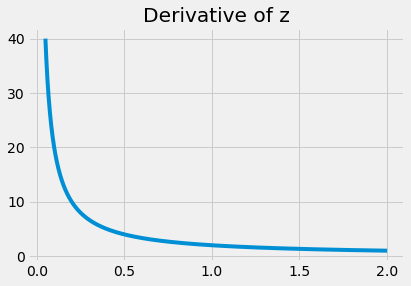

In [230]:
n = 1000
ws = torch.linspace(0.05, 2, n, requires_grad=True)
ys = ws**2
zs = torch.log(ys)
zs.backward(torch.ones([n]))  # note on gradient argument of backward method: https://stackoverflow.com/questions/43451125/pytorch-what-are-the-gradient-arguments
plt.plot(ws.detach(), ws.grad)
plt.title("Derivative of z");

It doesn't seem like much, but pytorch can also calculate derivatives of function with many arguments (like matrices), and having complicated, multidimensional operations in the middle and we don't have to worry about it.

Having gradients of the function, we can easily do optimization, either updating parameters directly or (more often) doing it via pytroch's optimizer.

## Training recurrent neural networks

### Data

In [234]:
def get_random_vector_sequence(vector_size: int):
    """Generates random sequence of vectors."""
    n_elements = np.random.poisson(5) + 1
    # Vectors are in rows, there is random number of vectors
    return torch.randn([n_elements, vector_size])

def get_x(n_samples: int, vector_size):
    """Generate random observations of sequences of vectors."""
    x_train = []
    for _ in range(n_samples):
        x_train.append(get_random_vector_sequence(vector_size))
    return x_train

def predict_y(xs: np.ndarray, *, sd=0.001):
    """
    True y based on sequence xs. 
    We could come up with various functinos and rules to compute y and see if RNN is able to learn it.
    It can allow us to test long-term dependencies and forgetting, which is important when evaluating RNN performance.
    """
    y = 0
    for i, x in enumerate(xs):
        y += sum(np.abs(x))  # what if we do not add absolute value here?
    return torch.tensor([y + np.random.normal(0, sd)])

In [237]:
# Getting data
n = 10_000
x_train = get_x(n, X_DIM)
y_true = torch.cat([predict_y(xs) for xs in x_train])

In [238]:
xs = x_train[0]
xs, predict_y(xs), torch.sum(xs)

(tensor([[-1.0510, -0.4686,  1.1756],
         [-1.6150,  0.4921, -1.3205],
         [ 0.1388, -0.7810,  0.0683],
         [-1.1469,  0.3412,  0.8841],
         [-1.3166, -0.4765,  0.6845],
         [ 0.8155, -0.2828,  1.4551],
         [-0.0427,  1.4307,  1.4279],
         [ 0.0925,  0.9884, -0.4703],
         [-0.8826, -0.6227, -0.0624],
         [ 0.9124,  0.3043, -0.0774],
         [ 1.6227,  0.6351,  0.3727]]),
 tensor([24.4599]),
 tensor(3.2249))

### Operations on tensors

In [249]:
X_DIM = 3
HIDDEN_DIM = 4
OUTPUT_DIM = 1
SD = 1e-2

# Note: SD * torch.randn([HIDDEN_DIM, X_DIM], requires_grad=True) won't work, because then W would be non-leaf variable 
# (created after some operation on tensor that requires grad)
W_xh = torch.empty([HIDDEN_DIM, X_DIM]).normal_(0, SD).requires_grad_()
W_hh = torch.empty([HIDDEN_DIM, HIDDEN_DIM]).normal_(0, SD).requires_grad_()
W_hy = torch.empty([OUTPUT_DIM, HIDDEN_DIM]).normal_(0, SD).requires_grad_()
b_h = torch.empty([HIDDEN_DIM, 1]).normal_(0, SD).requires_grad_()
b_y = torch.empty([OUTPUT_DIM, 1]).normal_(0, SD).requires_grad_()

parameters = (W_xh, W_hh, W_hy, b_h, b_y)

def nonlinearity(x):
    return torch.where(x > 0, x, torch.zeros_like(x))

def forward(xs):
    hidden_state = torch.zeros([HIDDEN_DIM, 1])
    for x in xs:
        x = x.reshape(-1, 1)
        hidden_state = nonlinearity(W_xh @ x + W_hh @ hidden_state + b_h)
    y = W_hy @ hidden_state + b_y
    return y

def batch_forward(x_train):
    y_pred = []
    for xs in x_train:
        y = forward(xs)
        y_pred.append(y)
    return torch.cat(y_pred)  # we have to make it a tensor in order for gradients to flow

In [250]:
losses = []

In [251]:
optimizer = optim.Adam(parameters, lr=0.1)

In [278]:
# Training RNN
n_iter = 50
for _ in trange(n_iter):
    optimizer.zero_grad()
    y_pred = batch_forward(x_train)
#     print("First predicted value: {:.4f}".format(y_pred[0].item()))
    # Calculating loss
    loss = torch.mean((y_pred - y_true)**2)
    # Optimizing
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
#     print("Current loss: {:.4f}".format(loss.item()))

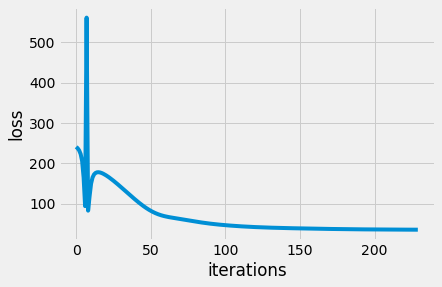

In [279]:
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("loss");

In [280]:
loss.item()**0.5

5.946132127204198

In [281]:
torch.mean((y_true - y_true.mean())**2)**0.5

tensor(5.8443)

## Evaluation

In [292]:
x_test = get_x(10_000, X_DIM)
y_true_test = torch.cat([predict_y(xs) for xs in x_test])
data_error = torch.mean((y_true_test - y_true_test.mean())**2)**0.5

y_pred_test = batch_forward(x_test)
test_error = torch.mean((y_pred_test - y_true_test)**2)**0.5

data_error.item(), test_error.item()

(5.884444236755371, 5.989275932312012)

## Summary
I wasn't very successful in training a recurrent neural network for a simple regression task. I think it would be worth it to come back to it later and analyze this exmple a little bit more. However, I think that the main ideas presented here were correct and this notebook may help in understanding inner workings of recurrent neural network.